# Spherical Quantum Dots Energy Spectrum

## Necessary modules

In [1]:
#Basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#Plot configuration in the notebook
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

#Sci-py utilities
from scipy import special
from scipy import optimize
import scipy.constants as scc
from scipy.integrate import trapz, quad
#Clecsch-Gordan coefficients
from sympy.physics.quantum.cg import CG

#Module to inspect funcitons
import inspect

#Modules for interactivity in jupyter notebook
import ipywidgets as ipw
from ipywidgets import interact, interact_manual
from IPython.display import display

In [6]:
#Remove warning - Helpful for testing
# import warnings
# warnings.filterwarnings("ignore")

## Necessary functions

### Infinite Spherical Well

In [7]:
def spherical_bessel(x,n):
    """Function required for find_spherical_bessel_roots
    """
    return special.spherical_jn(n,x)

def spherical_bessel_root(m,n):
    """Calculate m roots of the spherical bessel function of order n
    
    Args:
    m (int): number of roots
    n (int): order of the bessel function
    
    Return:
    roots
    """
    if n == 0:
        x_estimates = [(i+1)*np.pi for i in range(m+1)]
    else:
        x_estimates = [(i+n/2)*np.pi for i in range(m+1)]
    root = []
    for i in range(m):
        root.append(optimize.brentq(spherical_bessel,x_estimates[i],x_estimates[i+1] , args = (n,)))
        
    return root

### Finite Spherical Well

The spherical bessel functions can be calculated from the bessel functions using the following exprtession

$ f_l(x) = \sqrt{\frac{\pi}{2x}}F_l(x) $

where $f_l(x)$ represents any of the spherical functions (1st order bessel, 2nd order bessel or hankel) and $F_l(x)$ is the representation of the same function for the unaltered case


For the derivative the following expresion is used

$\frac{dh_l}{d\rho} = h_{l-1}-\frac{l+a}{\rho}h_l = \sqrt{\frac{\pi}{2x}}\left[H_{l-1/2}-\frac{l+1}{\rho}H_{l+1/2}\right]$

In [2]:
#Funcion to calculate the spherical hankel functions and its derivatives from the hankel funcitons
def spherical_hankel(n,x,kind,**kwargs):
    """Calculate spherical hankel funcions from the hankel functions
    Args:
        n (int): order of the spherical hankel function
        x (array): array with x data
        kind (int): kind of the hankel function (1 or 2) 
    **kwargs:
        derivative (bool): if true returns the derivative instead of the the value
    Return:
        sph_hankel (array): data for the spherical hankel function or its derivative
    """
    if kind == 1:#Calculate for first order hankel function
        if kwargs.get("derivative"):#If the derivative is asked 
            sph_hankel = np.sqrt((np.pi/(2*x)))*(special.hankel1(n-1/2,x)-((n+1)/x)*special.hankel1(n+1/2,x))
        else:
            sph_hankel = np.sqrt((np.pi/(2*x)))*special.hankel1(n+1/2,x)
    else:#Calculate second order hankel function
        if kwargs.get("derivative"):#If the derivative is asked 
            sph_hankel = np.sqrt((np.pi/(2*x)))*(special.hankel2(n-1/2,x)-((n+1)/x)*special.hankel2(n+1/2,x))
        else:
            sph_hankel = np.sqrt((np.pi/(2*x)))*special.hankel2(n+1/2,x)  
    return sph_hankel

#Solves the eigenvalue problem without any simplifations - NOT NECESSARY FOR FINAL FILE
def f_spherical_bound_states(E,m1,m2,a,V0,l):
    """Defines a function to solve the eigenstates in the spherical well by brute force
    Args:
        E (array): x range to calculate results (from 0 to -V0)
        m1,m2 (float): Effective masses inside and outside the well [m = m*.m_e]
        a (float): Radius of the well [nm]
        V0 (float): Potential barrier of the well [eV]
        l (int): order of the bessel function
    Returns:
        f_E: eigenvalue condition values
    """
    #Calculate normalization factors
    m1, m2, h_bar, V0, E = m1*9.1094, m2*9.1094, 1.05457, V0*1.6022, E*1.6022
    #Introducing the various bessel functions necessary
    #First kind bessel
    j_l = special.spherical_jn(l,np.sqrt((2*m1*(E+V0))/h_bar**2)*a)
    der_j_l = special.spherical_jn(l,np.sqrt((2*m1*(E+V0))/h_bar**2)*a,derivative = True)
    #First kind hankel
    h_l = spherical_hankel(l,np.sqrt((-2*m2*E/h_bar**2)*a*1j),1)
    der_h_l = spherical_hankel(l,np.sqrt((-2*m2*E/h_bar**2)*a*1j),1,derivative = True)
    f_E_1 = (der_j_l/j_l)
    f_E_2 = (np.sqrt(-(m2/m1)*(E/(E+V0)))*(der_h_l/h_l))
    #total function
    f_E = np.add(f_E_1,-1j*f_E_2)
    return np.real(f_E)

#Simplified condition to solve the eigenvalue condition
def spherical_bound_states(E,m1,m2,a,V0,l):
    """Function that returns the values of the eigenvalue condition
    For l = 0 uses the analitical solution to the problem
    For l > 0 solves the simplified verson of the eigenvalue condition
    Args:
        E (array): x range to calculate results (values from 0 to -V0)
        m1,m2 (float): Effective masses inside and outside the well [m = m*.m_e]
        a (float): Radius of the well [nm]
        V0 (float): Potential barrier of the well [eV]
        l (int): order of the bessel function
    Returns:
        f_E: argument and function result
    """
    if l == 0:#In this case solve the problem using the analitical solution
        f_E = f_spherical_l0(E,m1,m2,a,V0)
    else:#Solve the problem using the simplified solution
        #Calculate normalization factors
        m1, m2, h_bar, V0, E = m1*9.1094, m2*9.1094, 1.05457, V0*1.6022, E*1.6022
        E_j = np.sqrt(2*m1*(E+V0))*(a/h_bar) # argument of the bessel function
        E_h = np.sqrt(-2*m2*E)*(a/h_bar)*1j #argument of the hankel function
        #np.sqrt(-(m1/m2)*((E+V0)/E))*
        j_term = special.spherical_jn(l-1,E_j)/special.spherical_jn(l,E_j)
        #np.sqrt(-(m2/m1)*(E/(E+V0)))*
        h_term = np.sqrt(-(m2/m1)*(E/(E+V0)))*np.real(1j*(spherical_hankel(l-1,E_h,1)/spherical_hankel(l,E_h,1)))
        #h_term = (spherical_hankel(l-1,E_h,1)*spherical_hankel(l-1,E_h,2))/(spherical_hankel(l,E_h,1)*spherical_hankel(l,E_h,2))
        f_E = np.add(j_term,-h_term)
    return f_E

"""Analitical solutions to the problem"""
#Analitical Solution for l = 0
def f_spherical_l0(E,m1,m2,a,V0):
    """Return the results for the eigenvalue condition for l = 0
    Args:
        E (array): x range to calculate results (from 0 to -V0)
        m1,m2 (float): Effective masses inside and outside the well [m = m*.m_e]
        a (float): Radius of the well [nm]
        V0 (float): Potential barrier of the well [eV]
    Returns:
        f_E  (array): values for the eigenvalue condition
    """
    #Calculate normalization factors
    m1, m2, h_bar, V0, E = m1*9.1094, m2*9.1094, 1.05457, V0*1.6022, E*1.6022
    #E = np.linspace(0,-V0,500)
    arg_cot = np.sqrt(2*m1*(E+V0))*(a/h_bar)
    f_E = 1/np.tan(arg_cot)+np.sqrt(-(m2/m1)*(E/(E+V0)))
    return f_E

#Analitical solution for l = 1 - NOT NECESSARY FOR FINAL FILE
def f_spherical_l1(E,m1,m2,a,V0):
    """Return the results for the eigenvalue condition for l = 1
    Args:
        E (array): x range to calculate results
        m1,m2 (float): Effective masses inside and outside the well [m = m*.m_e]
        a (float): Radius of the well [nm]
        V0 (float): Potential barrier of the well [eV]
    Returns:
        f_E  (array): eigenvalue condition values
    """
    m1, m2, h_bar, V0, E = m1*9.1094, m2*9.1094, 1.05457, V0*1.6022, E*1.6022
    #E = np.linspace(0,-V0,500)
    kin = np.sqrt((2*m1*(E+V0))/(h_bar**2))
    kout = np.sqrt((-2*m2*E/(h_bar**2)))
    f_E = np.add(np.sin(kin*a)/((np.sin(kin*a)/(kin*a))-np.cos(kin*a)),np.sqrt(-(m2/m1)*(E/(E+V0)))*(1/(1+1/(kout*a))))
    return f_E

"""Calculation of zeros of the function"""
def zeros_f(func,x,**kwargs):
    """Calculate the zeros in the range defines by x
    Args:
        func (function): function to calculate the zeros
        x (array): array defining the range of values to calculate the zeros
    **kwargs:
        args = optinal argumentos for func
        tol = override the default tol of 0.1 (lower values lead to faster results but might be less accurate)
        fsolve = dictionary with overrides for fsolve
    Returns:
        zeros: array with the several zeros of the function
    """    
    #Check for tol override
    tol = 0.1
    if kwargs.get('tol'):
        tol = kwargs.get('tol')
    #Create a dictionary with additional arguments necessary for the function
    if kwargs.get('args'):
        #Associate variable name in the function with the value introduced in args
        f_variables = str(inspect.signature(spherical_bound_states))[1:-1].split(", ")[1:]
        f_args = dict()
        for (i,j) in zip(f_variables,range(len(f_variables))):
            f_args[i]=kwargs.get('args')[j]
        #Make a estimative for the location of the 0's  
        estimate_zeros = x[np.sqrt(np.abs(func(x,**f_args))) < tol]
    else:
        #Make a estimative for the location of the 0's  
        estimate_zeros = x[np.sqrt(np.abs(func(x))) < tol] 
    #Use fsolve combined with the previous 0 estimatives to determine the real 0s
    try:#To check if there are additional parameters to be used in fsolve
        zeros = optimize.fsolve(func, estimate_zeros,args = kwargs.get("args"),**kwargs.get('fsolve'))
    except:
        zeros = optimize.fsolve(func, estimate_zeros,args = kwargs.get("args"))
    #Remove duplicates
    zeros = np.unique(np.around(zeros,decimals=5))
    return zeros
                

## Other necessary functions

In [3]:
#Function to plot the absorption profiles
def absorption_ij(energy,t_energy,matrix_elements,gauss_dispersion = 0.025,qd_density = (1/50,1/50,1/50),n_index = 2):
    """
    Gaussian absortpion profile for energy transition from an initial to a final state
    Args:
        energy (array - eV): Base array to calculate y values
        t_energy (float - eV): Transition energy (term in the difference between initial and final states)
        gauss_dispersion (float - eV): Dispersion value for the gaussian (default - 0.025 eV)
        matrix_elements (tuple - nm): Matrix elements for the different polarizations
        qd_density (tuple nm^-1): linear qd density for the 3 different dimensions (default - (1/5nm,1/5nm,1/5nm))
        n_index (array): array with the refractive indexes - should have the same shape as energy (default = 2)
    Returns:
        abs_ij (array - cm^-1): Absorption for the transition i->j
    """
    #Initialize necessary constants
    q, h, c, e0 = 1.6022*10**-19, 6.626*10**-34, 2.9979*10**8, 8.8542*10**-12 #C,J.s,m/s,C^2/(N.m^2)
    #Convert matrix elements from nm to m
    matrix_elements_nm = matrix_elements*10**-9
    #Calculate the fraction responsible for the units
    constant_fraction = ((2*np.pi**2*q**2*energy)/(n_index*c*h*e0))
    #Fraction for the volumetrica part of the QDs in the bulk material and conversion to m
    rho_density = qd_density[0]*qd_density[1]*qd_density[2]*(10**9)**3
    volume_fraction = (6*rho_density)/np.pi#Volumetric fraction of QDs
    #Define the delta function in terms of a gaussian profiule
    delta = (1/(np.sqrt(np.pi)*sigma))*np.exp(-((energy-t_energy)/gauss_dispersion)**2)
    abs_ij = 2*matrix_elements_nm**2*constant_fraction*volume_fraction*delta
    return abs_ij/100

## QD class

In [4]:
#Class for the QD results
class qd_results():
    """
    Spherical Quantum Dot class. Calculates the energy levels, wavefunctions and radial and speherical matrix elements given a, V0, m1 and m2.
    Methods:
        __init__: initializes the varibles (a,V0,m1,m2) of the QD and calculates the energy levels and normalization constants
        energy_levels (Automatic initialization): Dataframe attribute (e_levels) with the energy levels
        norm_constants (Automatic initialization): Dataframe attribute (k_in,k_out,norm_A,norm_B) with k values and normalization constants
        norm_wavefunction: Returns the normalized probability density for a given l (orbital angular momentum),n (energy level index) values
        rad_matrix_element: Returns the radial matrix element between an initial (li,ni) and final (lf,nf) states
        ang_matrix_element: Returns the 3 angular matrix components element between an initial (li,mi) and final (lf,mf) states
    """
    
    def __init__(self,a,V0,m1,m2):#Initialize the QD values
        """
        Initialization function
        Args:
            a (nm): size of the qd
            V0 (eV): energy of the potential barrier
            m1 and m2 (*me): effective masses inside and outside the qd in function of the electrom mass
        """
        self.a = a
        self.V0 = V0
        self.m1 = m1
        self.m2 = m2
        self.energy_levels()
        self.norm_constants()
        
    def energy_levels(self):#Pandas DataFrame with the Energy Levels
        """
        Calculates the energy eigenvalue (is immediately initialized when the class is called)
        """
        e_geom = -self.V0+np.geomspace(0.001,self.V0,100000,endpoint=True)#Define the e values
        zeros = dict()
        l_ind = 0
        #Cicle to calculate all zeros
        while True:
            try:
                zeros[f"l{l_ind}"]=zeros_f(spherical_bound_states,e_geom,args = (self.m1,self.m2,self.a,self.V0,l_ind))
            except:
                break
            l_ind += 1
        self.e_levels = pd.DataFrame.from_dict(zeros,orient='index').transpose()
    
    def norm_constants(self):#Calculates the normalization constants
        """
        Calculate the k_in, k_out and normalization constants (is immediately initialized when the class is called)
        """
        #Change units necessary for calculations
        m_1, m_2, h, V_0 = self.m1*9.1094, self.m2*9.1094, 1.05457, self.V0*1.6022
        #calculate k_in and k_out for all energy eigenvalues
        self.k_in = pd.DataFrame(np.sqrt(2*m_1*(self.e_levels.values*1.6022+V_0))/h,columns=self.e_levels.columns)
        self.k_out = pd.DataFrame(np.sqrt(-2*m_2*self.e_levels.values*1.6022)/h,columns=self.e_levels.columns)
        #initialize dataframe for the constant values and the wavefunctions
        self.norm_A = pd.DataFrame()
        self.norm_B = pd.DataFrame()
        #Cicle to calculate all
        for li in self.k_in.columns:
            j_li_ka = np.absolute(special.spherical_jn(int(li[1:]),self.k_in[li].values*self.a))**2
            h_li_ka = np.absolute(spherical_hankel(int(li[1:]),1j*self.k_out[li].values*self.a,kind = 1))**2
            a_j_li = np.array([quad(lambda x: special.spherical_jn(int(li[1:]),k_in_i*x)**2*x**2,0,self.a)[0] for k_in_i in self.k_in[li].values])
            b_h_li = np.array([quad(lambda x: np.absolute(spherical_hankel(int(li[1:]),1j*k_out_i*x,kind = 1))**2*x**2,self.a,np.inf)[0] for k_out_i in self.k_out[li].values])
            self.norm_A[li] = h_li_ka/(a_j_li*h_li_ka+b_h_li*j_li_ka)
            self.norm_B[li] = j_li_ka/(a_j_li*h_li_ka+b_h_li*j_li_ka)
    
    def norm_wavefunction(self,l,n,**kwargs):#Determine te normalization constants for a certain level
        """
        Calculates the normalized probability density for a range (default = 2*a)
        Args:
            l - angular momentum
            n - index of the energy level for a given n
        Returns:
            radius - the radius values used for the calculation
            wavefunction - normalized probabuility density
        """
        r_in = np.linspace(0,self.a,200)
        r_out = np.linspace(self.a,self.a*2,200)
        radius = np.concatenate([r_in, r_out])
        wavefunction = np.concatenate([self.norm_A.iloc[n,l]*special.spherical_jn(l,r_in*self.k_in.iloc[n,l])**2,self.norm_B.iloc[n,l]*np.absolute(spherical_hankel(l,1j*r_out*self.k_out.iloc[n,l],kind = 1))**2])
        return radius,wavefunction 
    
    def rad_matrix_element(self,i_state,f_state):#Calculates the radial matrix elements
        """
        Calculate matrix elements for a certain initial and final state
        Args:
            i_state (tuple): index of the initial state (l,n)
            f_state (tuple): index of the final state
        Returns:
            rad_element: radial elemement of the transition
        """
        #Obtain the respective normalization constants
        norm_Ai, norm_Af = np.sqrt(self.norm_A.iloc[i_state[1],i_state[0]]), np.sqrt(self.norm_A.iloc[f_state[1],f_state[0]])
        norm_Bi, norm_Bf = np.sqrt(self.norm_B.iloc[i_state[1],i_state[0]]), np.sqrt(self.norm_B.iloc[f_state[1],f_state[0]])
        #Obtain the respective k_values involved
        k_in_i, k_in_f = self.k_in.iloc[i_state[1],i_state[0]], self.k_in.iloc[f_state[1],f_state[0]]
        k_out_i,k_out_f = self.k_out.iloc[i_state[1],i_state[0]], self.k_out.iloc[f_state[1],f_state[0]]
        #Integration of the bessel part
        bessel_integration = quad(lambda x: np.conj(norm_Af)*norm_Ai*special.spherical_jn(i_state[0],x*k_in_i)*special.spherical_jn(f_state[0],x*k_in_f)*x**3,0,self.a)[0]
        #Integration of the hankel part
        hankel_integration = quad(lambda x: np.conj(norm_Bf)*norm_Bi*np.conj(spherical_hankel(f_state[0],1j*k_out_f*x,kind = 1))*spherical_hankel(i_state[0],1j*k_out_i*x,kind = 1)*x**3,self.a,np.inf)[0]
        return bessel_integration+hankel_integration
    
    def ang_matrix_element(self,i_state,f_state):
        """
        Calculates the angular part of the matrix elements
        Args:
            i_state (tuple): l and m values for the initial state
            f_state (tuple): l and m values for the final state
        Returns:
            ep_x,ep_circ_1,ep_circ_2: Components for each polarization
        """
        li, mi = i_state
        lf, mf = f_state
        pre_factor = np.sqrt((2*li+1)/(2*lf+1))*CG(1,0,li,0,lf,0).doit()
        ep_z = pre_factor*CG(1,0,li,mi,lf,mf).doit()#z polarization
        ep_circ_left = pre_factor*CG(1,-1,li,mi,lf,mf).doit()*(1/np.sqrt(2))#left circular polarization (ex+iey)
        ep_circ_right = pre_factor*CG(1,1,li,mi,lf,mf).doit()*(1/np.sqrt(2))#right circular polarization (-ex+iey)
        return ep_z,ep_circ_left,ep_circ_right#Calculates the angular matrix elements#Calculates the angular matrix element#Calculates the angular matrix elements between an initial li,mi and final lf,mf states#Calculates a single angular matrix element for a specific m and l values
    
    def all_ang_matrix_elements(self,li,lf):#Calculates all the elements between m-values for a given li and lf
        """
        Calculates the total transition rate given an inital and final l values
        Args:
            li: initial value for the orbital angular momentum
            lf: final value for the orbital angular momentum
        Retuns:
            ang_elements: numpy array, size (2*lf+1,2*li+1,3) with all the matrix elements between transitions
        """
        #Calculate the pre-factor in the sum
        #pre_factor = 1/((2*lf+1)*(2*li+1))
        #Create a list with all the necessary m values
        m_i = np.arange(-li,li+1)
        m_f = np.arange(-lf,lf+1)
        M_i,M_f = np.meshgrid(m_i,m_f)#Create an array with the parameters variations
        M_i,M_f = list(M_i.flatten()),list(M_f.flatten())#Flatten the data to use in the map function
        ang_elements = np.array(list(map(lambda x,y: self.ang_matrix_element((li,x),(lf,y)),M_i,M_f)),dtype=float).reshape(2*lf+1,2*li+1,3)
        #Create a wighting factor to average the results for each polarization
        avg_weight_factor = np.zeros_like(ang_elements)
        avg_weight_factor[ang_elements!=0] = 1
        average_ang_elements = np.average(ang_elements,axis=(0,1),weights = avg_weight_factor)
        return ang_elements, average_ang_elements

## Energy level calculations for infinite potential spherical QD

Radial part of Schrodinger equation for central potentials:

\begin{equation}\label{eq:1}
    -\frac{\hbar^2}{2\mu}\left(\frac{d^2}{dr^2}+\frac{2}{r}\frac{d}{dr} - \frac{l(l+1)}{r^2}\right)R_{nl}(r)+V(r)R_{nl}(r) = E_{nl}R_{nl}(r)
\end{equation}

### The free particle

The free particle equation: $\left(k^2 = \frac{2\mu E}{\hbar^2}\right)$

\begin{equation}\label{eq:2}
    \left(\frac{d^2}{dr^2}+\frac{2}{r}\frac{d}{dr} - \frac{l(l+1)}{r^2}\right)R(r) + k^2R(r) = 0
\end{equation}

Solutions for the free particle problem ($\rho = kr$)

Regular solution(spherical bessel function)

\begin{equation}\label{eq:3}
    j_l(\rho) = (-\rho)^l\left(\frac{1}{\rho}\frac{d}{d\rho}\right)^l\left(\frac{\sin\rho}{\rho}\right)
\end{equation}

Irregular solution (spherical Neumann function)

\begin{equation}\label{eq:4}
    n_l(\rho) = -(-\rho)^l\left(\frac{1}{\rho}\frac{d}{d\rho}\right)^l\left(\frac{\cos\rho}{\rho}\right)
\end{equation}

Composite solutions (linear combination of Bessel and Von Newmann solutions)

\begin{equation}\label{eq:5}
    h_l^{1/+}(\rho) = j_l(\rho) + in_l(\rho)\\
    h_l^{2/-}(\rho) = j_l(\rho) - in_l(\rho)
\end{equation}


#### Graphical plotting of the solutions

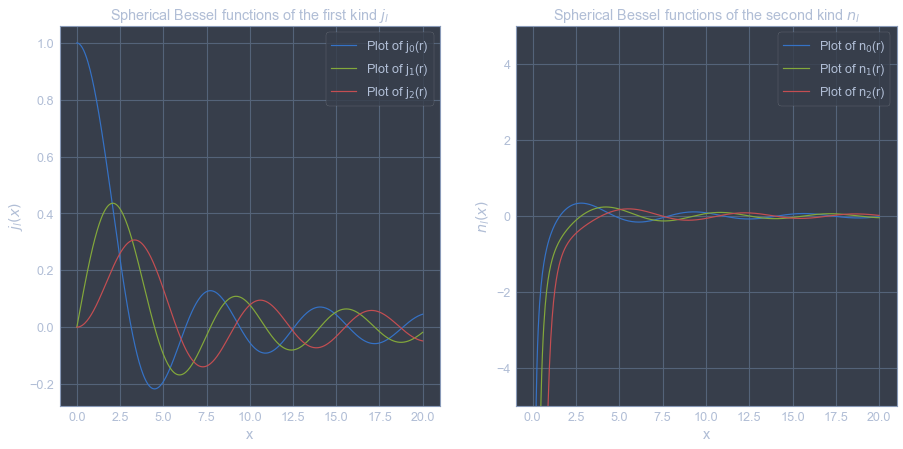

In [78]:
#Bessel functions
x = np.linspace(0,20,500)
j = [special.spherical_jn(i,x) for i in range(3)]
y = [special.spherical_yn(i,x) for i in range(3)]
fig, ax = plt.subplots(1,2,figsize = (15,7))

for (j_i,y_i,i) in zip(j,y,range(3)):
    ax[0].plot(x,j_i,label = "Plot of j$_" + str(i) + "$(r)")
    ax[1].plot(x,y_i,label = "Plot of n$_" + str(i) + "$(r)")

ax[0].legend(); ax[0].set_ylabel("$j_l(x)$"); ax[0].set_xlabel("x");
ax[0].set_title("Spherical Bessel functions of the first kind $j_l$");
ax[1].legend(); ax[1].set_ylim((-5,5)); ax[1].set_ylabel("$n_l(x)$"); ax[1].set_xlabel("x");
ax[1].set_title("Spherical Bessel functions of the second kind $n_l$");


### The infinite spherical well

Infinite Spherical Well

\begin{align*}
    V(r) &= 0, \quad r\leqslant a\\
         &= \infty, \quad r>a
\end{align*}

Solutions must be regular (irregular blows up near 0)

\begin{equation}\label{eq:6}
    R(r) = Aj_l(kr)
\end{equation}

Then the eigenvalue condition becomes

\begin{equation}\label{eq:7}
    j_l(ka) = 0
\end{equation}

Root finding can use the limits from the formula $ka = \left(n+\frac{1}{2}l\right)\pi$


In [79]:
#Calculate eigenvalues for the infinite spherical well
l = [0,1,2,3,4,5,6]
x = np.linspace(0,20,100)
j = np.stack([special.spherical_jn(li,x) for li in l]) 

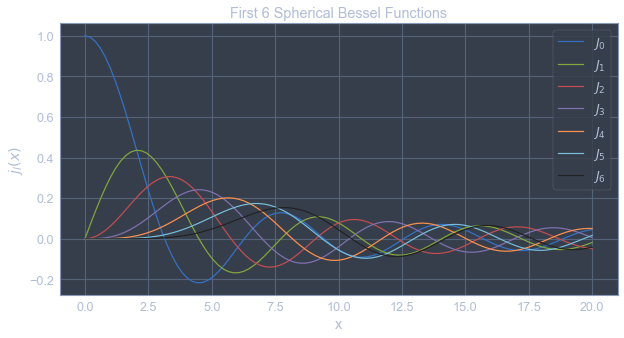

In [80]:
#Plot the spherical bessel functions
for i in l:
    plt.plot(x,j[i],label = "$J_" + str(i)+ "$")
plt.legend(); plt.xlabel("x"); plt.ylabel("$j_l(x)$");
plt.title("First 6 Spherical Bessel Functions");

Table with the first 5 zeros of the first 6 angular momentum values (l)

In [83]:
#Find roots the first 5 roots
roots = np.stack([spherical_bessel_root(5,i) for i in l]).transpose()
cols  = ["$J_"+str(i)+"$" for i in l]
data = pd.DataFrame(roots, columns=cols)
data

,$J_0$,$J_1$,$J_2$,$J_3$,$J_4$,$J_5$,$J_6$
0,3.141593,4.493409,5.763459,6.987932,8.182561,9.355812,10.512835
1,6.283185,7.725252,9.095011,10.417119,11.704907,12.966530,14.207392
2,9.424778,10.904122,12.322941,13.698023,15.039665,16.354710,17.647975
3,12.566371,14.066194,15.514603,16.923621,18.301256,19.653152,20.983463
4,15.707963,17.220755,18.689036,20.121806,21.525418,22.904551,24.262768


## Energy level calculation for the finite spherical well

### Solutions to the problem

Finite Spherical Well Bound States $(E<0)$

\begin{align*}
    V(r) &= -V_0, \quad &r\leqslant a\\
         &= 0, \quad &r>a
\end{align*}

Here there are 2 independent solutions for each part of the potential

Inside the well $(V = -V_0)$

$k_{in}=\frac{\sqrt{2m^*(E+V_0)}}{\hbar}>0$

The solutions become (the only acceptable solutions are the spherical bessel)

\begin{equation}\label{eq:8}
    R(r) = A_{in}j_l(k_{in}r)
\end{equation}

Outside the well $(V = 0)$

$k_{out}=\frac{\sqrt{2m^*(E)}}{\hbar} = jk_{out}$

The solutions are as follows ($R_l(ik_{out}r)\rightarrow 0$ as $r \rightarrow\infty$) (only the first kind spherical hankel functions are acceptable)

\begin{equation}\label{eq:}
    R_l = A_{out}h^1_l(ik_{out}r)
\end{equation}

In [84]:
#Check 1st order hankel functions behaviour
x = np.linspace(0,5,100)
y = np.stack([np.real(spherical_hankel(i,x*1j,1)) for i in range(7)])

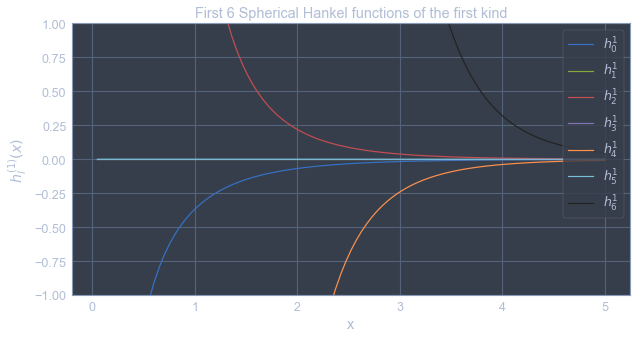

In [85]:
for i in range(7):
    plt.plot(x,y[i],label = "$h^1_" + str(i)+ "$")
plt.legend(loc = 1); plt.xlabel("x"); plt.ylabel("$h_l^{(1)}(x)$");
plt.title("First 6 Spherical Hankel functions of the first kind");
plt.ylim((-1,1));

In [86]:
#Check behaviour of 2nd order hankel functions
x = np.linspace(0,10,100)
y = np.stack([spherical_hankel(i,x*1j,2) for i in range(7)])

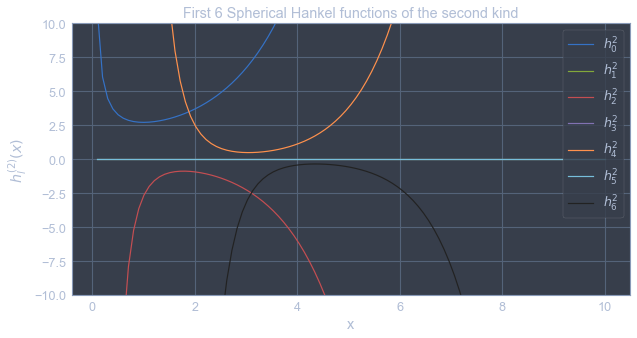

In [87]:
for i in range(7):
    plt.plot(x,y[i],label = "$h^2_" + str(i)+ "$")
plt.legend(loc = 1); plt.xlabel("x"); plt.ylabel("$h_l^{(2)}(x)$");
plt.title("First 6 Spherical Hankel functions of the second kind");
plt.ylim((-10,10));

### Boundary Conditions

#### Equations

Boundary conditions

\begin{equation}\label{eq:10}
    k_{in}\left(\frac{\frac{dj_l(\rho)}{d\rho}}{j_l(\rho)}\right)_{\rho = k_{in}a} = ik_{out}\left(\frac{\frac{dh_l(\rho)}{d\rho}}{h_l(\rho)}\right)_{\rho=ik_{out}a}
\end{equation}


For l = 0, then the above equation reduces to

\begin{equation}\label{eq:11}
    -\cot\left(\sqrt{\frac{2m_1(E+V_0)}{\hbar^2}}a\right)=\sqrt{-\frac{m_2}{m_1}\frac{-E}{V_0+E}}
\end{equation}


Eigenvalue condition for any l by brute force

\begin{equation}\label{eq:12}
    \sqrt{\frac{-m_1(E+V_0)}{m_2E}}\frac{j_l^\prime\left(\sqrt{\frac{2m_1(E+V_0)}{\hbar^2}}a\right)}{j_l\left(\sqrt{\frac{2m_1(E+V_0)}{\hbar^2}}a\right)} - i\frac{h_l^\prime\left(i\sqrt{\frac{-2m_2E)}{\hbar^2}}a\right)}{h_l\left(i\sqrt{\frac{-2m_2E}{\hbar^2}}a\right)} = 0
\end{equation}


The eigenvalue condition can be simplified for the following expression

\begin{equation}\label{eq:13}
    \sqrt{\frac{-m_1(E+V_0)}{m_2E}}\frac{j_{l-1}\left(\sqrt{\frac{2m_1(E+V_0)}{\hbar^2}}a\right)}{j_l\left(\sqrt{\frac{2m_1(E+V_0)}{\hbar^2}}a\right)} - i\frac{h_{l-1}\left(i\sqrt{\frac{-2m_2E)}{\hbar^2}}a\right)}{h_l\left(i\sqrt{\frac{-2m_2E}{\hbar^2}}a\right)} = 0
\end{equation}


Simplification factores

$m_{1/2} = m_{1/2}^{\dagger}\times10^{-31}, \quad     m_{1/2}^{\dagger}= m_1^*\times 9.1094$

$\hbar = \hbar^{\dagger}\times10^{-34}, \quad            \hbar^{\dagger} = 1.05457$

$(E+V_0) = (E+V_0)^{\dagger}\times10^{-19}, \quad        (E+V_0)^{\dagger} = (E+V_0)[eV]\times 1.6022$

$\frac{dh_l}{d\rho} = h_{l-1}-\frac{l+1}{\rho}h_l$

$\frac{dj_l}{d\rho} = j_{l-1}-\frac{l+1}{\rho}j_l$

#### Term analysis

Hankel fraction without

\begin{equation}\label{eq:14}
    i\frac{h_{l-1}\left(i\sqrt{\frac{-2m_2E}{\hbar^2}}a\right)}{h_l\left(i\sqrt{\frac{-2m_2E}{\hbar^2}}a\right)}
\end{equation}

Hankel fraction with the energy factor


\begin{equation}\label{eq:15}
    i\sqrt{-\frac{m_2E}{m_1(E+V_0)}}\frac{h_{l-1}\left(i\sqrt{\frac{-2m_2E}{\hbar^2}}a\right)}{h_l\left(i\sqrt{\frac{-2m_2E}{\hbar^2}}a\right)}
\end{equation}

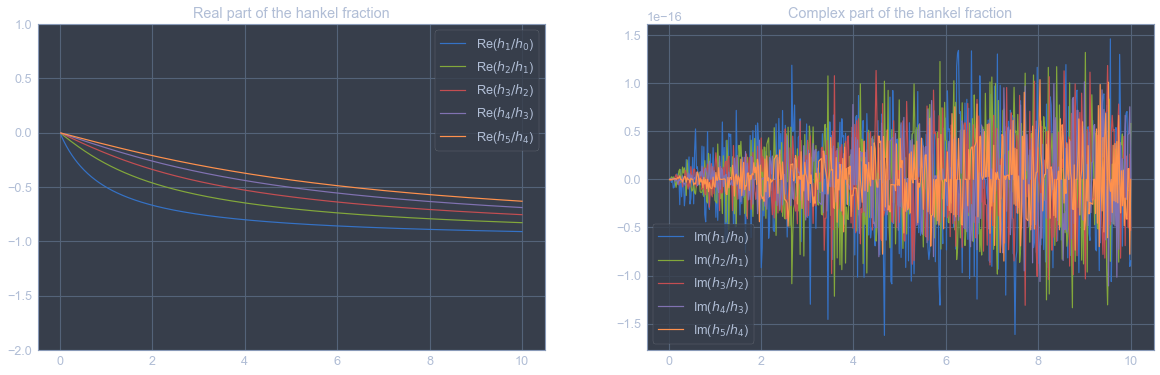

In [88]:
#Test related to the real and imaginary components of the fraction
x = np.linspace(0,10,500)
num_h = [spherical_hankel(i,1j*x,1) for i in range(5)]
denom_h = [spherical_hankel(i+1,1j*x,1) for i in range(5)]

frac_1 = [1j*np.divide(num_h[i],denom_h[i]) for i in range(5)]

fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (20,6))

for i in range(5):
    ax[0].plot(x,np.real(frac_1[i]),label = "Re($h_{}/h_{}$)".format(i+1,i))
    ax[1].plot(x,np.imag(frac_1[i]),label = "Im($h_{}/h_{}$)".format(i+1,i))
    
ax[1].legend();
ax[0].legend();
ax[0].set_ylim(-2,1);
ax[1].set_title("Complex part of the hankel fraction");
ax[0].set_title("Real part of the hankel fraction");

In [89]:
h = ipw.IntSlider(min = 1,max = 20, step = 1)
h

IntSlider(value=1, max=20, min=1)

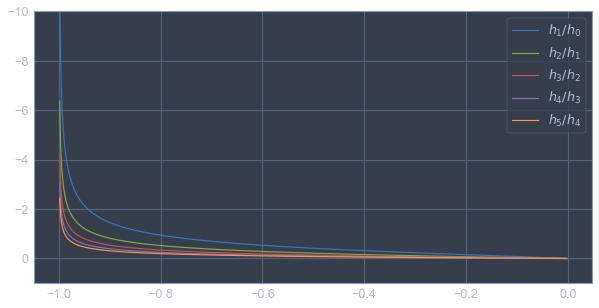

In [93]:
#Test related with the positioning of the fraction
x = np.linspace(0,-1,500)
num_h = [spherical_hankel(i,1j*np.sqrt(-x)*h.value,1) for i in range(5)]
denom_h = [spherical_hankel(i+1,1j*np.sqrt(-x)*h.value,1) for i in range(5)]

frac_1 = [1j*np.sqrt(-x/(x+1))*np.divide(num_h[i],denom_h[i]) for i in range(5)]

for i in range(5):
    plt.plot(x,np.real(frac_1[i]),label = "$h_{}/h_{}$".format(i+1,i))
    
plt.legend();
plt.ylim(1,-10);

Test for the bessel fraction with the square root

\begin{equation}\label{eq:16}
    \sqrt{\frac{-m_1(E+V_0)}{m_2E}}\frac{j_{l-1}\left(\sqrt{\frac{2m_1(E+V_0)}{\hbar^2}}a\right)}{j_l\left(\sqrt{\frac{2m_1(E+V_0)}{\hbar^2}}a\right)}
\end{equation}

In [94]:
j = ipw.IntSlider(min = 1,max = 20, step = 1)
j

IntSlider(value=1, max=20, min=1)

(-10, 10)

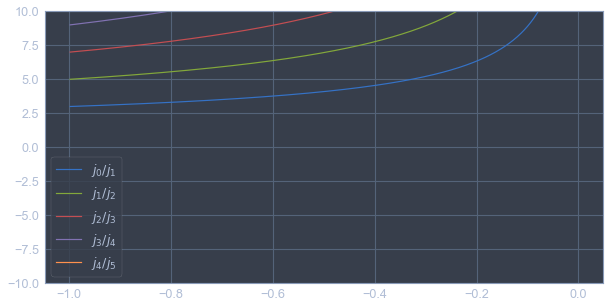

In [95]:
#Test related with the positioning of the fraction
x = np.linspace(0,-1,500)
num_j = [special.spherical_jn(i,np.sqrt(x+1)*j.value) for i in range(5)]
denom_j = [special.spherical_jn(i+1,np.sqrt(x+1)*j.value) for i in range(5)]

frac_1 = [np.sqrt(-(x+1)/x)*np.divide(num_j[i],denom_j[i]) for i in range(5)]

for i in range(5):
    plt.plot(x,np.real(frac_1[i]),label = "$j_{}/j_{}$".format(i,i+1))
    
plt.legend();
plt.ylim((-10,10))

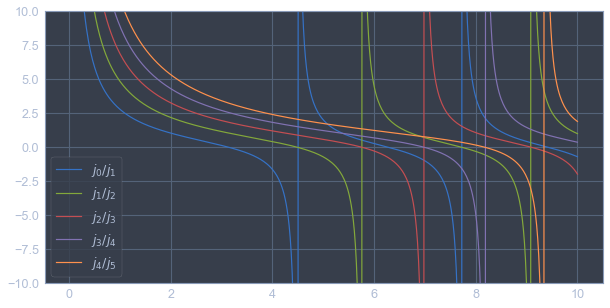

In [96]:
#Bessel functions without the fraction
x = np.linspace(0,10,500)
num_j = [special.spherical_jn(i,x) for i in range(5)]
denom_j = [special.spherical_jn(i+1,x) for i in range(5)]

frac_1 = [np.divide(num_j[i],denom_j[i]) for i in range(5)]

for i in range(5):
    plt.plot(x,np.real(frac_1[i]),label = "$j_{}/j_{}$".format(i,i+1))
    
plt.legend();
plt.ylim((-10,10));

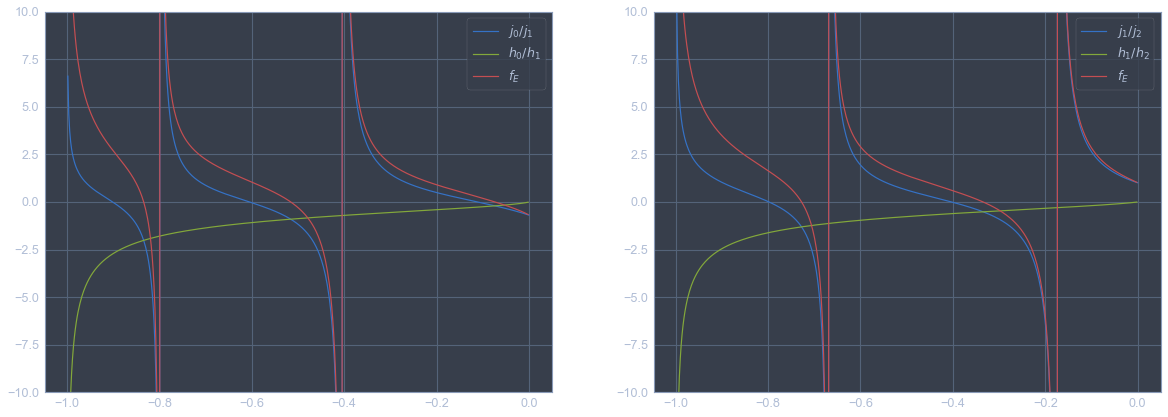

In [97]:
#Combining the fractions

#Fraction on the hankel function
x = np.linspace(0,-1,500)
num_j = [special.spherical_jn(i,np.sqrt(x+1)*10) for i in range(2)]
denom_j = [special.spherical_jn(i+1,np.sqrt(x+1)*10) for i in range(2)]
num_h = [spherical_hankel(i,1j*np.sqrt(-x)*10,1) for i in range(2)]
denom_h = [spherical_hankel(i+1,1j*np.sqrt(-x)*10,1) for i in range(2)]

frac_1, frac_2 = np.stack([np.divide(num_j[i],denom_j[i]) for i in range(2)]), np.stack([1j*np.sqrt(-x/(x+1))*np.divide(num_h[i],denom_h[i]) for i in range(2)])
f_E = frac_1-frac_2

fig, ax = plt.subplots(nrows=1,ncols=2,figsize= (20,7))
for i in range(2):
    ax[i].plot(x,np.real(frac_1[i]),label = "$j_{}/j_{}$".format(i,i+1))
    ax[i].plot(x,np.real(frac_2[i]),label = "$h_{}/h_{}$".format(i,i+1))
    ax[i].plot(x,np.real(f_E[i]),label = "$f_E$".format(i,i+1))
    
ax[0].legend();
ax[0].set_ylim((-10,10));
ax[1].legend();
ax[1].set_ylim((-10,10));

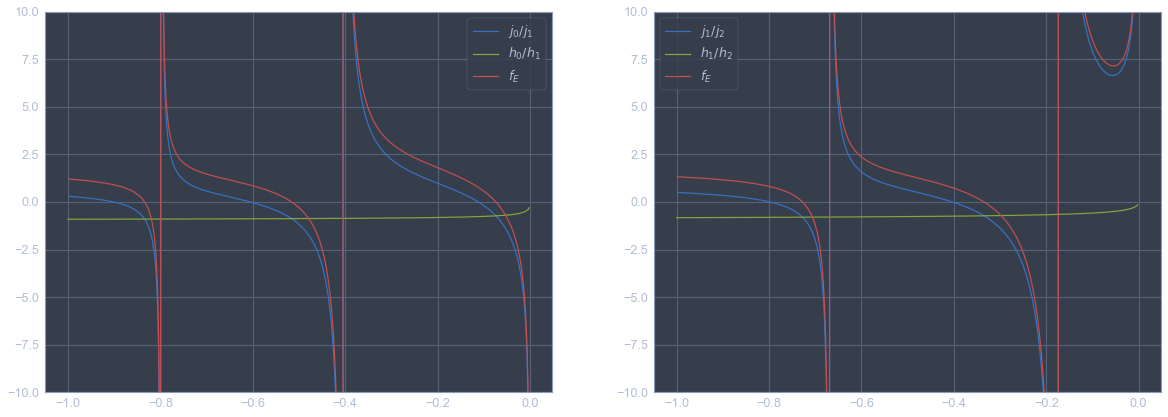

In [98]:
#Combining the fractions

#Fraction on the hankel function
x = np.linspace(0,-1,500)
num_j = [special.spherical_jn(i,np.sqrt(x+1)*10) for i in range(2)]
denom_j = [special.spherical_jn(i+1,np.sqrt(x+1)*10) for i in range(2)]
num_h = [spherical_hankel(i,1j*np.sqrt(-x)*10,1) for i in range(2)]
denom_h = [spherical_hankel(i+1,1j*np.sqrt(-x)*10,1) for i in range(2)]

frac_1, frac_2 = np.stack([np.sqrt(-(x+1)/x)*np.divide(num_j[i],denom_j[i]) for i in range(2)]), np.stack([1j*np.divide(num_h[i],denom_h[i]) for i in range(2)])
f_E = frac_1-frac_2

fig, ax = plt.subplots(nrows=1,ncols=2,figsize= (20,7))
for i in range(2):
    ax[i].plot(x,np.real(frac_1[i]),label = "$j_{}/j_{}$".format(i,i+1))
    ax[i].plot(x,np.real(frac_2[i]),label = "$h_{}/h_{}$".format(i,i+1))
    ax[i].plot(x,np.real(f_E[i]),label = "$f_E$".format(i,i+1))
    
ax[0].legend();
ax[0].set_ylim((-10,10));
ax[1].legend();
ax[1].set_ylim((-10,10));

Solutions for the brute force method, considering m$_1$ and m$_2 = 1\times m_e$, V$_0$ = -1 eV and a = 1 nm

In [100]:
V0 =1
E = np.linspace(0,-V0,500)#Introducing negative E
eigen = []
for i in range(5):
    cond = f_spherical_bound_states(E,1,1,1,1,i)
    eigen.append(cond)

eigen = np.stack(eigen)
mask = (eigen > 20) | (eigen < -20)
eigen[mask]=np.nan

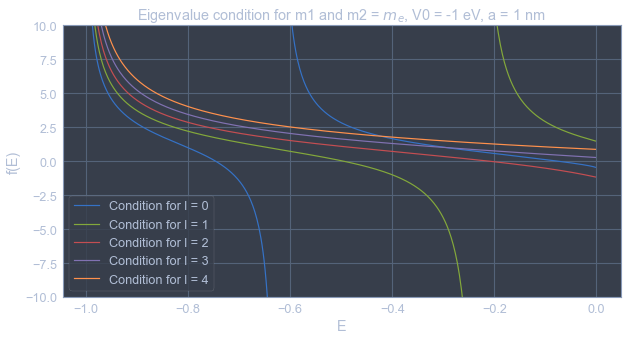

In [101]:
for i in range(5):
    plt.plot(E,eigen[i],label = "Condition for l = {}".format(i));
plt.ylim((-10,10));
plt.ylabel("f(E)");
plt.xlabel("E");
plt.legend();
plt.title("Eigenvalue condition for m1 and m2 = $m_e$, V0 = -1 eV, a = 1 nm");

#### Interactive eigenvalues brute force

In [103]:
#Interactive representation for the first 5 l's
@interact_manual(m1 = (0.0,1.0,0.1),
          m2 = (0.0,1.0,0.1),
          V0 = (0.0,1.0,0.1),
          a = (0.0,10.0,0.1))
def interact_eigen(m1=0.5,m2 = 0.5, V0 = 0.5,a = 1.0):
    #First calculate the values for plotting
    E = np.linspace(0,-V0,500)#Introducing negative E
    eigen = []
    for i in range(5):
        cond = f_spherical_bound_states(E,m1,m2,a,V0,i)
        eigen.append(cond)
    #Remove descontinuities
    eigen = np.stack(eigen)
    mask = (eigen > 20) | (eigen < -20)
    eigen[mask]=np.nan
    
    for i in range(5):
        plt.plot(E,eigen[i],label = "Condition for l = {}".format(i));
        plt.ylim((-10,10));
        plt.ylabel("f(E)");
        plt.xlabel("E");
        plt.legend();

interactive(children=(FloatSlider(value=0.5, description='m1', max=1.0), FloatSlider(value=0.5, description='m…

#### Second method to solve eigenvalue condition

Analitical equation for l = 1

\begin{equation}\label{eq:17}
    \frac{\sin(k_{in}a)}{\frac{\sin(k_{in}a)}{k_{in}a}-\cos(k_{in}a)}=\frac{k_{out}}{k_{in}}\frac{1}{1+\frac{1}{k_{out}a}}
\end{equation}


In [122]:
#Resultados para o caso analitico
@interact_manual(a = (0.1,10,0.1),m1 = (0.1,1,0.1),m2 = (0.1,1,0.1),V0 = (0.1,1,0.1))
def compare_analitical(m1=1,m2=1,a=1,V0 = 10):
    E_l1 = np.linspace(0,-V0,500)#Introducing negative E
    f_e_anal = f_spherical_l1(E,m1,m2,a,V0);
    f_e_num = spherical_bound_states(E,m1,m2,a,V0,1);

    plt.plot(E_l1,f_e_anal,E_l1,f_e_num);
    plt.legend(("Analitical solution","Numerical solution"));
    plt.ylim(-10,10);

interactive(children=(FloatSlider(value=1.0, description='m1', max=1.0, min=0.1), FloatSlider(value=1.0, descr…

In [106]:
@interact_manual(a = (0.1,10,0.1),m1 = (0.1,2,0.1),m2 = (0.1,2,0.1),V0 = (0.1,2,0.1), l = (0,10,1))
def plot_interact(a = 3,m1 = 0.5,m2 = 0.5,V0 = 1,l=1):
    E = np.linspace(0,-V0,700)
    f_E = spherical_bound_states(E,m1,m2,a,V0,l)
    plt.plot(E,f_E,label = "l = {}".format(l))
    plt.ylim((-10,20))
    plt.xlabel("E (eV)");
    plt.ylabel("f_E");
    plt.legend()

interactive(children=(FloatSlider(value=3.0, description='a', max=10.0, min=0.1), FloatSlider(value=0.5, descr…

#### Method testing

This problem only has solutions if

\begin{equation}\label{eq:18}
    a^2V_0>\frac{\hbar^2\pi^2}{8m_1}
\end{equation}


Comparison in the limit of presence of eigenvalue

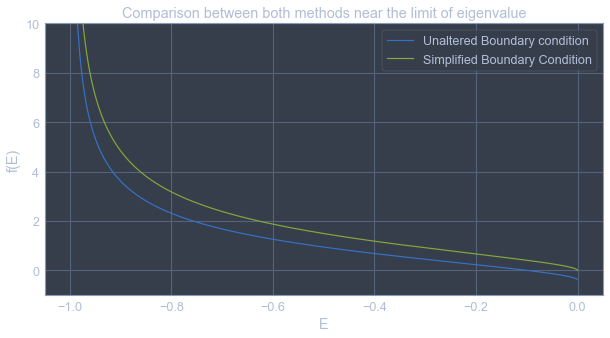

In [108]:
#Comparison for value of a near the threshold
x = np.linspace(0,-1,1000)
#a_vals = np.linspace(0.1,0.4,0.05)
brute = f_spherical_bound_states(x,1,1,0.3066,1,0)
simple = spherical_bound_states(x,1,1,0.3066,1,0)

plt.plot(x,brute,x,simple);
plt.legend(("Unaltered Boundary condition","Simplified Boundary Condition"));
plt.ylim((-1,10));plt.ylabel("f(E)");plt.xlabel("E");
plt.title("Comparison between both methods near the limit of eigenvalue");

Comparison for multiple values of a

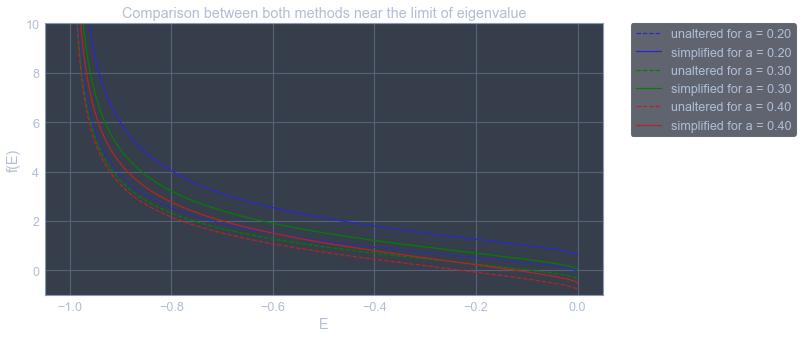

In [124]:
#Comparison for multiple values of a near the eigenvalue threshold
x = np.linspace(0,-1,1000)
a_vals = np.linspace(0.2,0.4,3)
brute = [f_spherical_bound_states(x,1,1,a_val,1,0) for a_val in a_vals]
simple = [spherical_bound_states(x,1,1,a,1,0) for a in a_vals]
color = ['#2828CC','green','#B72424']
for i in range(len(a_vals)):
    plt.plot(x,brute[i],label = "unaltered for a = {0:1.2f}".format(a_vals[i]),linestyle= "--",color = color[i]);
    plt.plot(x,simple[i],label = "simplified for a = {0:1.2f}".format(a_vals[i]),color = color[i]);

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
plt.ylim((-1,10));plt.ylabel("f(E)");plt.xlabel("E");
plt.title("Comparison between both methods near the limit of eigenvalue");

Comparison for increasing a values

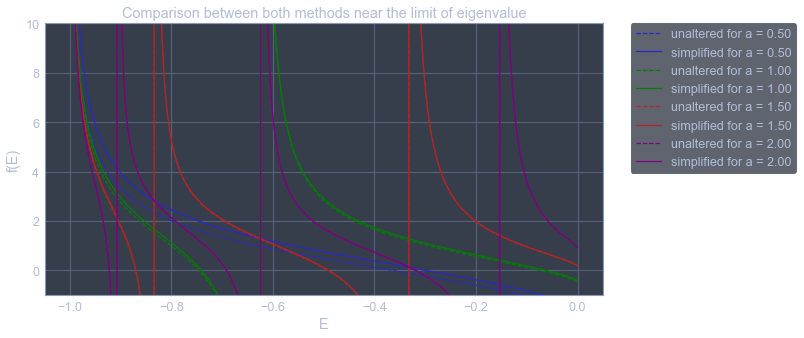

In [125]:
#Comparison for a value going further from the threshold
x = np.linspace(0,-1,1000)
a_vals = np.linspace(0.5,2,4)
brute = [f_spherical_bound_states(x,1,1,a_val,1,0) for a_val in a_vals]
simple = [spherical_bound_states(x,1,1,a,1,0) for a in a_vals]
color = ['#2828CC','green','#B72424','purple']
for i in range(len(a_vals)):
    plt.plot(x,brute[i],label = "unaltered for a = {0:1.2f}".format(a_vals[i]),linestyle= "--",color = color[i]);
    plt.plot(x,simple[i],label = "simplified for a = {0:1.2f}".format(a_vals[i]),color = color[i]);

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
plt.ylim((-1,10));plt.ylabel("f(E)");plt.xlabel("E");
plt.title("Comparison between both methods near the limit of eigenvalue");

Comparison with analitical for l = 1

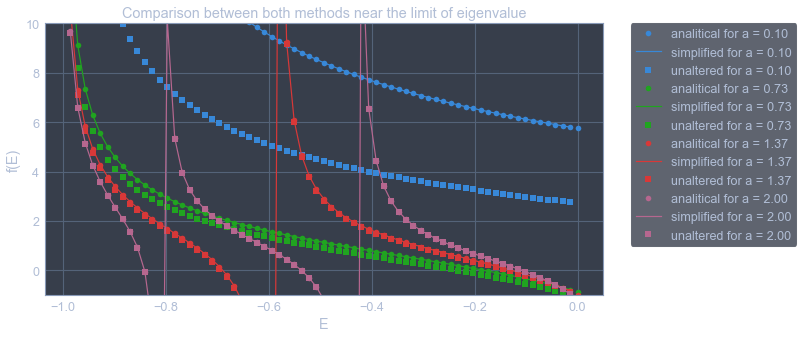

In [126]:
#Comparison for several a values
x = np.linspace(0,-1,70)
a_vals = np.linspace(0.1,2,4)
anal = [f_spherical_l1(x,1,1,a_val,1) for a_val in a_vals]
simple = [spherical_bound_states(x,1,1,a,1,1) for a in a_vals]
brute =[f_spherical_bound_states(x,1,1,a,1,1) for a in a_vals]
color = ['#3888D8','#20A420','#D83838','#B6678F']
for i in range(len(a_vals)):
    plt.plot(x,anal[i],'o',label = "analitical for a = {0:1.2f}".format(a_vals[i]),color = color[i]);
    plt.plot(x,simple[i],label = "simplified for a = {0:1.2f}".format(a_vals[i]),color = color[i]);
    plt.plot(x,brute[i],'s',label = "unaltered for a = {0:1.2f}".format(a_vals[i]),color = color[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
plt.ylim((-1,10));plt.ylabel("f(E)");plt.xlabel("E");
plt.title("Comparison between both methods near the limit of eigenvalue");

Comparison for  l = 2

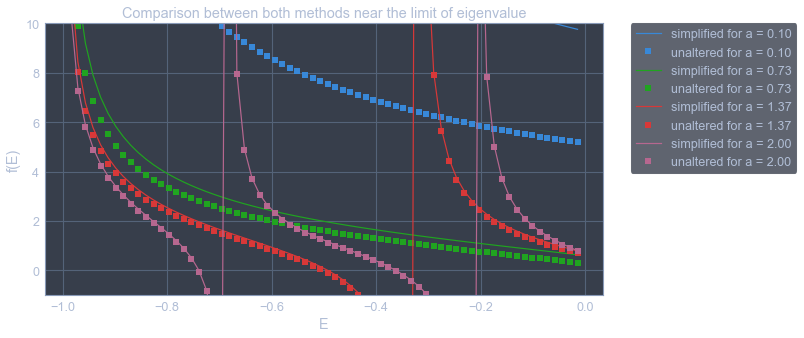

In [127]:
#Comparison for several a values
x = np.linspace(0,-1,70)
a_vals = np.linspace(0.1,2,4)
simple = [spherical_bound_states(x,1,1,a,1,2) for a in a_vals]
brute =[f_spherical_bound_states(x,1,1,a,1,2) for a in a_vals]
color = ['#3888D8','#20A420','#D83838','#B6678F']
for i in range(len(a_vals)):
    plt.plot(x,simple[i],label = "simplified for a = {0:1.2f}".format(a_vals[i]),color = color[i]);
    plt.plot(x,brute[i],'s',label = "unaltered for a = {0:1.2f}".format(a_vals[i]),color = color[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
plt.ylim((-1,10));plt.ylabel("f(E)");plt.xlabel("E");
plt.title("Comparison between both methods near the limit of eigenvalue");

Results for l = 1 with decreasing m1 instead of radius

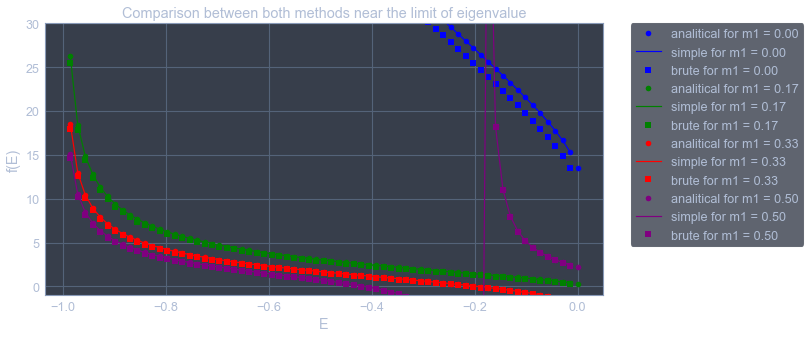

In [129]:
#Comparison for several m1 values
x = np.linspace(0,-1,70)
m1_vals = np.linspace(0.001,0.5,4)
anal = [f_spherical_l1(x,m1,1,1.37,1) for m1 in m1_vals]
simple = [spherical_bound_states(x,m1,1,1.37,1,1) for m1 in m1_vals]
brute =[f_spherical_bound_states(x,m1,1,1.37,1,1) for m1 in m1_vals]
color = ['blue','green','red','purple']
for i in range(len(m1_vals)):
    plt.plot(x,anal[i],'o',label = "analitical for m1 = {0:1.2f}".format(m1_vals[i]),color = color[i]);
    plt.plot(x,simple[i],label = "simple for m1 = {0:1.2f}".format(m1_vals[i]),color = color[i]);
    plt.plot(x,brute[i],'s',label = "brute for m1 = {0:1.2f}".format(m1_vals[i]),color = color[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
plt.ylim((-1,30));plt.ylabel("f(E)");plt.xlabel("E");
plt.title("Comparison between both methods near the limit of eigenvalue");

Comparison for very high radius size

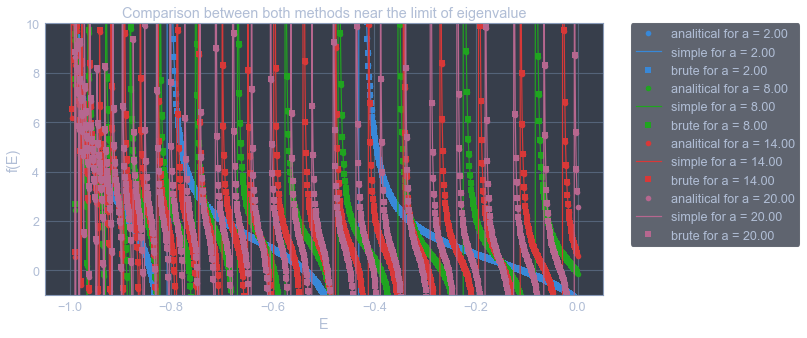

In [132]:
#Comparison for several a values
x = np.linspace(0,-1,800)
a_vals = np.linspace(2,20,4)
anal = [f_spherical_l1(x,1,1,a_val,1) for a_val in a_vals]
simple = [spherical_bound_states(x,1,1,a,1,1) for a in a_vals]
brute =[f_spherical_bound_states(x,1,1,a,1,1) for a in a_vals]
color = ['#3888D8','#20A420','#D83838','#B6678F']
for i in range(len(a_vals)):
    plt.plot(x,anal[i],'o',label = "analitical for a = {0:1.2f}".format(a_vals[i]),color = color[i]);
    plt.plot(x,simple[i],label = "simple for a = {0:1.2f}".format(a_vals[i]),color = color[i]);
    plt.plot(x,brute[i],'s',label = "brute for a = {0:1.2f}".format(a_vals[i]),color = color[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
plt.ylim((-1,10));plt.ylabel("f(E)");plt.xlabel("E");
plt.title("Comparison between both methods near the limit of eigenvalue");

#### Calculating the energy sectrum

In [10]:
#Animation for calculation of zeros
@interact_manual(m1 = (0.000,1.000,0.001),m2 = (0.000,1.000,0.001),a = (0.5,10,0.1),V0 = (0.000,1.000,0.001))
def zeros_animation(m1 = 0.500,m2 = 0.500,a = 3,V0 = 0.500):
#Plot data
    e_lin = np.linspace(0,-V0,8000)
    zeros = dict()
    e_geom = -V0+np.geomspace(0.001,V0,100000,endpoint=True)
    l_ind = 0
    #Cicle to calculate all zeros
    while True:
        try:
            zeros[f"l{l_ind}"]=zeros_f(spherical_bound_states,e_geom,args = (m1,m2,a,V0,l_ind))
        except:
            break
        l_ind += 1
    #Plot data
    fig,ax = plt.subplots(figsize = (20,10))
    for i in range(l_ind+1):
        ax.plot(e_lin,spherical_bound_states(e_lin,m1,m2,a,V0,i),label = f"l = {i}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);ax.set_ylim((-10,10));
    df = pd.DataFrame.from_dict(zeros,orient='index').transpose()
    display(df)

interactive(children=(FloatSlider(value=0.5, description='m1', max=1.0, step=0.001), FloatSlider(value=0.5, de…

#### Evaluation of partwise functions

Lastly, we should also calculate the normalization constants A and B.
The normalization condition is as follows

\begin{equation}\label{eq:19}
    \int_{0}^{a}A^2j_l^2(k_{in}r)r^2dr + \int_{a}^{\infty}B^2h_l^{(1)^2}(k_{out}r)r^2dr = 1\\
    a_{j_l}A^2 + b_{h_l^{(1)}}B^2 = 1
\end{equation}

Since there are infinitely many solutions, an aditional constraint should be added. As such we will use the continuity boundary condition
\begin{equation}\label{eq:20}
    \begin{cases}
     a_{j_l}A^2 + b_{h_l}B^2 = 1\\ 
    Aj_l(k_{in}a) - Bh_l^{(1)}(k_{out}a) = 0\\
    \end{cases}
\end{equation}


The solutions are as follows
\begin{equation}\label{eq:21}
    A^2 = \frac{|h_l^{(1)}(k_{out}a)|^2}{a|h_l^{(1)}(k_{out}a)|^2+b|j_l(k_{in}a)|^2}
\end{equation}

\begin{equation}\label{eq:22}
    B^2 = \frac{|j_l(k_{in}a)|^2}{a|h_l^{(1)}(k_{out}a)|^2+b|j_l(k_{in}a)|^2}
\end{equation}

For this part we will consider a potential with a = 1 nm, V$_0$ = 1 eV and m$_1^*$ = m$_2^*$ = m$_e$

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


,l0,l1,l2,l3,l4,l5,l6
0,-0.92215,-0.84109,-0.73921,-0.61772,-0.47758,-0.31965,-0.14492
1,-0.69119,-0.53609,-0.36213,-0.17238,NaN,NaN,NaN
2,-0.31920,-0.10759,NaN,NaN,NaN,NaN,NaN


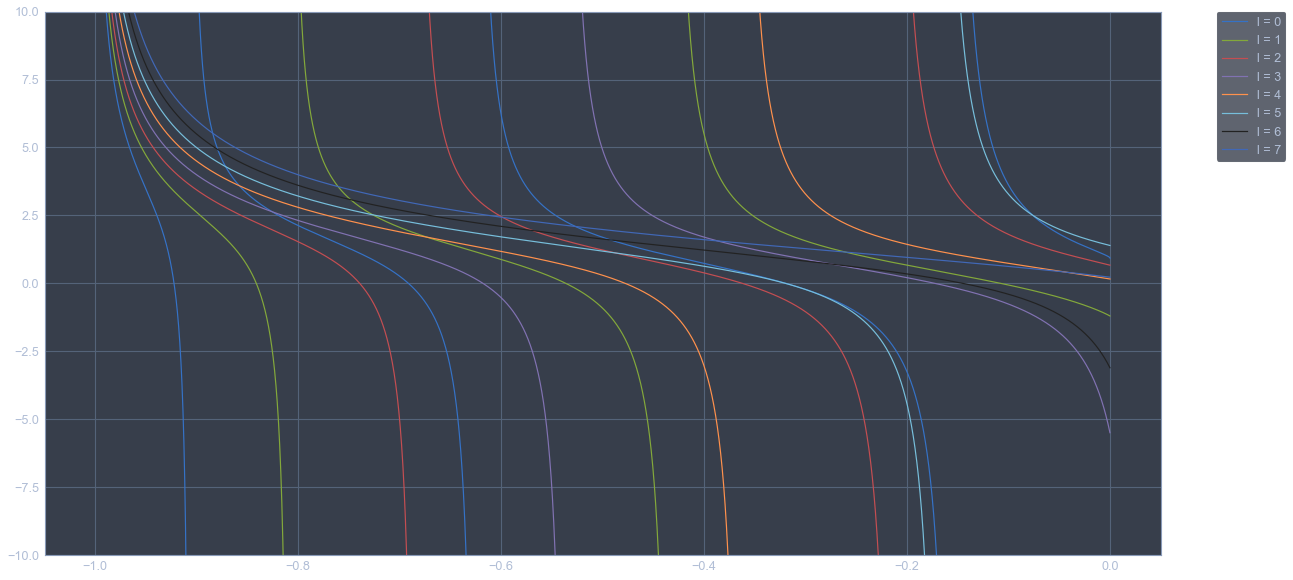

In [15]:
#Plot eigenvalue condition and calculate the zeros
V0,a,m1,m2 = 1,2,1,1
e_lin = np.linspace(0,-V0,8000)
e_geom = -V0+np.geomspace(0.001,V0,100000,endpoint=True)
zeros = dict()
l_ind = 0
#Cicle to calculate all zeros
while True:
    try:
        zeros[f"l{l_ind}"]=zeros_f(spherical_bound_states,e_geom,args = (m1,m2,a,V0,l_ind))
    except:
        break
    l_ind += 1
#Plot data
fig,ax = plt.subplots(figsize = (20,10))
for i in range(l_ind+1):
    y_data = spherical_bound_states(e_lin,m1,m2,a,V0,i)
    mask = (y_data<-50)|(y_data>50)
    y_data[mask] = np.nan
    ax.plot(e_lin,y_data,label = f"l = {i}")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);ax.set_ylim((-10,10));
#Print table with the zeros
df = pd.DataFrame.from_dict(zeros,orient='index').transpose()
display(df)

In [17]:
#Adjusting constant values
m_1, m_2, h, V_0 = m1*9.1094, m2*9.1094, 1.05457, V0*1.6022

In [28]:
#Varying energy
@interact_manual(e = (-1,0,0.001),l=(0,4,1))
def mathching_wf(e, l = 0,a = 1):
    k_in = np.sqrt(2*m_1*(e*1.6022+V_0))/h
    k_out = np.sqrt(-2*m_2*e*1.6022)/h
    r_in = np.linspace(0,a,500)
    r_out = np.linspace(a,a+1,500)
    print("k_in | k_out :")
    print(k_in,k_out)

    j_l_ka = np.absolute(special.spherical_jn(l,k_in*a))**2
    h_l_ka = np.absolute(spherical_hankel(l,k_out*1j*a,kind = 1))**2
    a_j_l = quad(lambda x: special.spherical_jn(l,k_in*x)**2*x**2,0,a)[0]
    b_h_l = quad(lambda x: np.absolute(spherical_hankel(l,1j*k_out*x,kind = 1))**2*x**2,a,np.inf)[0]
    print("j_l_ka | h_l_ka | a_j_l | b_h_l :")
    print(j_l_ka,h_l_ka,a_j_l,b_h_l)
    A_2 = h_l_ka/(a_j_l*h_l_ka+b_h_l*j_l_ka)
    B_2 = j_l_ka/(a_j_l*h_l_ka+b_h_l*j_l_ka)
    print("A_2 | B_2 :")
    print(A_2,B_2)
    #B_2 = (1-a_j_l*(h_l_ka/j_l_ka))/b_h_l
    #A_2 = (1-b_h_l*B_2)/a_j_l
    #Plotting the normalized wave-functions
    j_in = A_2*np.absolute(special.spherical_jn(l,r_in*k_in))**2
    h_out = B_2*np.absolute(spherical_hankel(l,r_out*k_out*1j,kind = 1))**2
    plt.plot(r_in,j_in,r_out,h_out);plt.xlim(0,a+1);

interactive(children=(FloatSlider(value=-1.0, description='e', max=0.0, min=-1.0, step=0.001), IntSlider(value…

### Energy Transitions

Considering the dipole aproximation the transition rate is determined by:

\begin{equation}\label{eq:23}
\Gamma_{i\rightarrow j} = \frac{\pi q^2\omega}{\epsilon_r\epsilon_0 V}\left|\left\langle\phi_j \left| \epsilon^{(\lambda)}\cdot\vec{r} \right| \phi_i\right\rangle\right|^2\delta(E_j-E_k\mp\hbar\omega)
\end{equation}


Solving the matrix elements

\begin{equation}\label{eq:24}
    \left\langle\phi_j \left| \epsilon^{(\lambda)}\cdot\vec{r} \right| \phi_i\right\rangle = \int_0^\infty r^3 dr R^*_{n_fl_f}(r)R_{n_il_i}(r)\times\int d\Omega Y^*_{n_fl_f}(\theta,\phi)\epsilon^{(\lambda)}\cdot\hat{r}Y_{n_il_i}(\theta,\phi)
\end{equation}


In [22]:
#Solution to the radial part of the integral (to incorporate in the qd class)
#Create test variable
a = 1;
radial_int = pd.DataFrame()
test_r_int = qd_results(a,1,1,1) #Solve spherical qd problem for basic variable
for li in test_r_int.norm_A.columns:
    print(test_r_int.k_in[li].values,test_r_int.norm_A[li].values)
    bessel_integration = np.array([quad(lambda x: A_i*special.spherical_jn(int(li[1:]),k_in_i*x)**2*x**3,0,a)[0] for (k_in_i,A_i) in zip(test_r_int.k_in[li].values,test_r_int.norm_A[li].values)])
    print(bessel_integration)
    hankel_integration = np.array([quad(lambda x: B_i*np.absolute(spherical_hankel(int(li[1:]),1j*k_out_i*x,kind = 1))**2*x**3,a,np.inf)[0] for (k_out_i,B_i) in zip(test_r_int.k_out[li].values,test_r_int.norm_B[li].values)])
    print(hankel_integration)
    radial_integral = bessel_integration + hankel_integration
    radial_int[li] = radial_integral

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less


[2.60761227 4.96307363] [11.08559612 27.57077833]
[0.56006422 0.3175853 ]
[0.05331206 0.57582799]
[3.6980621       nan] [22.52315477         nan]
[0.61822384        nan]
[0.12516882        nan]
[4.6833891       nan] [34.73253649         nan]
[0.59270753        nan]
[0.26225635        nan]


C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


In [21]:
test = qd_results(1,1,1,1)


C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [23]:
test = qd_results(1,1,1,1)
test.matrix_element((2,0),(1,0))

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\si

0.595865901222594

Determination of the angular integral

First, the development of the operator inside the integral leads to
\begin{equation}\label{eq:25}
\epsilon\cdot\hat{r} = \sqrt\frac{4\pi}{3}\left(\epsilon_zY_{1,0}+\frac{-\epsilon_x+i\epsilon_y}{\sqrt{2}}Y_{1,1}+\frac{\epsilon_x+i\epsilon_y}{\sqrt{2}}Y_{1,-1}\right)
\end{equation}

This basically corresponds to the matrix element relating the "polarization" of the incident photon with the angular momentum of the electron.

The angular integral is then composed of three different factors (depending on the incident radiation)

\begin{align}
     \int d\Omega Y^*_{n_fl_f}(\theta,\phi)\epsilon^{(\lambda)}\cdot\hat{r}Y_{n_il_i}(\theta,\phi) &= \epsilon_z\sqrt{\frac{4\pi}{3}}\int d\Omega Y^*_{l_f,m_f}Y_{1,0}Y_{l_i,m_i}\\
     &= \frac{\epsilon_x+i\epsilon_y}{\sqrt{2}}\sqrt{\frac{4\pi}{3}}\int d\Omega Y^*_{l_f,m_f}Y_{1,-1}Y_{l_i,m_i}\\
     &= \frac{-\epsilon_x+i\epsilon_y}{\sqrt{2}}\sqrt{\frac{4\pi}{3}}\int d\Omega Y^*_{l_f,m_f}Y_{1,1}Y_{l_i,m_i}\\
\end{align}



To solve the angular part, the following relation is useful

\begin{align}
    \left\langle Y_{l_1}^{m_1} \left| Y_{l_2}^{m_2} \right| Y_{l_3}^{m_3} \right\rangle &= \\
    &= \int_0^{2\pi}\int_0^\pi (Y_{l_1}^{m_1})^* Y_{l_2}^{m_2} Y_{l_3}^{m_3} \sin(\theta)d\theta d\phi\\
    &= \sqrt{\frac{(2l_2+1)(2l_3+1)}{4\pi(2l_1+1)}}C(l_2l_3l_1|000)C(l_2l_3l_1|m_2m_3m_1)
\end{align}

Where $C(l_1l_2l_3|m_1m_2m_3)$ are the Clebsch-Gordon Coefficients that are automaticly implemented in python's simpy

The matrix element then becomes

\begin{align}
\left\langle\phi_j \left| \epsilon^{(\lambda)}\cdot\vec{r} \right| \phi_i\right\rangle\ &= \int_0^\infty r^3 dr R^*_{n_fl_f}(r)R_{n_il_i}(r)\times\int d\Omega Y^*_{n_fl_f}(\theta,\phi)\epsilon^{(\lambda)}\cdot\hat{r}Y_{n_il_i}(\theta,\phi)\\
                        &= \int_0^\infty r^3 dr R^*_{n_fl_f}(r)R_{n_il_i}(r)\times\left(\epsilon_z\sqrt{\frac{4\pi}{3}}\int d\Omega Y^*_{l_f,m_f}Y_{1,0}Y_{l_i,m_i}+\frac{\epsilon_x+i\epsilon_y}{\sqrt{2}}\sqrt{\frac{4\pi}{3}}\int d\Omega Y^*_{l_f,m_f}Y_{1,-1}Y_{l_i,m_i}+ \frac{-\epsilon_x+i\epsilon_y}{\sqrt{2}}\sqrt{\frac{4\pi}{3}}\int d\Omega Y^*_{l_f,m_f}Y_{1,1}Y_{l_i,m_i}\right)\\
                        &= \sqrt{\frac{(2l_i+1)}{(2l_f+1)}}\int_0^\infty r^3 dr R^*_{n_fl_f}(r)R_{n_il_i}(r)\times\left(\epsilon_zC(1l_il_f|000)C(1l_3l_1|0m_im_f)+\frac{\epsilon_x+i\epsilon_y}{\sqrt{2}}C(1l_il_f|000)C(1l_il_f|-1m_im_f)+ \frac{-\epsilon_x+i\epsilon_y}{\sqrt{2}}C(1l_il_f|000)C(1l_il_f|1m_im_f)\right)\\
\end{align}


In [13]:
CG(1,1,1,1,1,1)*CG(1,1,1,1,1,1).doit()

0

In [8]:
def angular_comps(li,mi,lf,mf):
    ep_z = CG(1,li,lf,0,0,0)*CG(1,li,lf,0,mi,mf).doit()
    ep_circ_1 = CG(1,li,lf,0,0,0)*CG(1,li,lf,-1,mi,mf).doit()*(1/np.sqrt(2))
    ep_circ_2 = CG(1,li,lf,0,0,0)*CG(1,li,lf,1,mi,mf).doit()*(1/np.sqrt(2))
    return ep_z,ep_circ_1,ep_circ_2

In [7]:
angular_comps(1,0,2,-1)

(0, 0, 0)

Given the transition rate for a specific level, the absortpion coefficient can be determined, considering the QD volumetrc density by:

\begin{equation}\label{eq:35}
    \alpha_{i\rightarrow f} = \frac{2\pi q^2 E}{n_{ref} ch\epsilon_0}\left| \left\langle\phi_j \left| \epsilon^{(\lambda)}\cdot\vec{r} \right| \phi_i\right\rangle\ \right|^2 \frac{6}{\pi}\rho_{qd}\delta(E_f-E_i-\hbar\omega)f_i(1-f_f)
\end{equation}

Where f$_i$ and f$_f$ are the fermi factors for the initial and final states respectivelly and $\rho_{qd}$ is the density of quantum dots in the material

# Spherical Well for PbS Quantum Dots

## Test and implementation of the script - Energy Levels + Wavefunctions

The following calculations will be done using the following materials properties

PbS
Eg = 0.4 eV
m* = 0.08 me

Perovskite
Eg = 1.55 eV
m* = 0.08 eV

size - variable (1-10 nm)

In [39]:
#Calculate a minimum limit

a_min = 1.0546*np.pi/np.sqrt(8*1.602*1.15*0.08*9.1)
print(a_min)

1.0114555004208634


In [10]:
#Calculate energy level dispersion with size
for a_i in np.linspace(1,10,50):
    print('-----------------------------')
    print(a_i)
    data = qd_results(a_i,1.15,0.08,0.08)
    print(data.e_levels)
    print(data.norm_constants)

-----------------------------
1.0
Empty DataFrame
Columns: []
Index: []
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x000002413185A488>>
-----------------------------
1.183673469387755
        l0
0 -0.05626
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x000002413185AD08>>
-----------------------------
1.3673469387755102


C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in less


        l0
0 -0.16821
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x0000024131831DC8>>
-----------------------------
1.5510204081632653
       l0
0 -0.2843
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x0000024131829648>>
-----------------------------
1.7346938775510203
        l0
0 -0.38956
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x00000241307CDE88>>
-----------------------------
1.9183673469387754
        l0
0 -0.48085
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x0000024131829648>>
-----------------------------
2.1020408163265305
        l0       l1
0 -0.55878 -0.03909
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x000002413181E848>>
-----------------------------
2.2857142857142856
        l0       l1
0 -0.62505 -0.13827
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x0000024131831348>>
-------------------

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


        l0       l1       l2
0 -0.83794 -0.52336 -0.14821
1 -0.03818      NaN      NaN
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x0000024131817F48>>
-----------------------------
3.3877551020408165
        l0       l1       l2
0 -0.86504 -0.57607 -0.22706
1 -0.10473      NaN      NaN
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x00000241307EFCC8>>
-----------------------------
3.5714285714285716
        l0       l1      l2
0 -0.88882 -0.62272 -0.2985
1 -0.17422      NaN     NaN
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x0000024131822A08>>
-----------------------------
3.7551020408163267
        l0       l1       l2       l3
0 -0.90978 -0.66413 -0.36289 -0.02035
1 -0.24100      NaN      NaN      NaN
<bound method qd_results.norm_constants of <__main__.qd_results object at 0x00000241317EDF48>>
-----------------------------
3.938775510204082
        l0       l1       l2       l3
0 -0.92835 -0.7

limit_output extension: Maximum message size of 10000 exceeded with 10243 characters

In [6]:
#Obtain data for the fundamental energy level
e0 = list()
for index,i in enumerate(test):
    if index > 0:
        e0.append(i.e_levels.values[0,0])
    else:
        continue

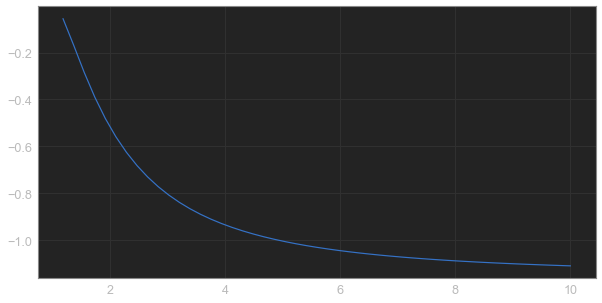

In [7]:
plt.plot(a[1:],e0)
##Export data
np.savetxt("E0_with_size.txt",np.array([a[1:],e0]).T)

In [76]:
#Base filepath
filepath = "D:\\IBSC\\Resultados\\"

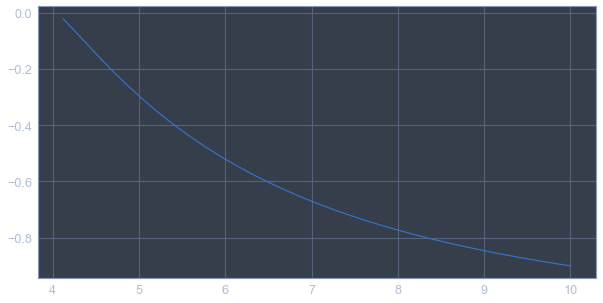

In [128]:
#Energy levels for the first excited states
index = 0
energy = list()
for i in test:
    n_energy = np.count_nonzero(~np.isnan(i.e_levels.values))#Determine the number of energy values (excluding nan)
    if n_energy > 5:#At least one eigenvalue
        energy.append(i.e_levels.values[1,1])
    else:
        index += 1#iteration to know where the first 2nd energy level appears
        
plt.plot(a[index:],energy)
np.savetxt(filepath+f"E5_with_size.txt",np.array([a[index:],energy]).T)

In [131]:
test[index-1].e_levels

,l0,l1,l2,l3
0,-0.92835,-0.70099,-0.42086,-0.09818
1,-0.30334,NaN,NaN,NaN


Results obtained using Manuel's 'best' values

+ V0 = 2 eV
+ m* = 0.08 me
+ a = [1, 10 nm]

## Test 2D Scatter Plot for Wavefunctions

In [4]:
#Calculate a minimum limit

a_min = 1.0546*np.pi/np.sqrt(8*1.602*2*0.08*9.1)
print(a_min)

0.7669741076892238


In [5]:
#Obtain the energy level dispersion
V = 2; m1 = 0.08; m2 = 0.08;
a = np.linspace(1,10,50)
manuel_results = [qd_results(a_i,V,m1,m2) for a_i in a]

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\si

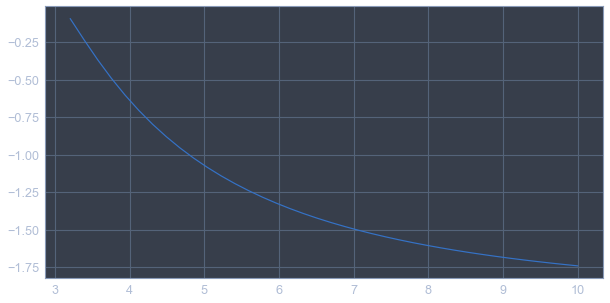

In [12]:
#Cicle to calculate the energy levels for the first 5 states - it works one by one
index = 0
energy = list()
for i in manuel_results:
    n_energy = np.count_nonzero(~np.isnan(i.e_levels.values))#Determine the number of energy values present (excluding nan)
    if n_energy > 5:#At least one eigenvalue
        energy.append(i.e_levels.values[1,1])
    else:
        index += 1#iteration to know where the first 2nd energy level appears

plt.plot(a[index:],energy)
np.savetxt(f"E5_with_size.txt",np.array([a[index:],energy]).T)

In [13]:
#Obtain Probability density profiles for the first levels
# a = 4 nm
qd_scatter_data = qd_results(4,2,0.08,0.08)

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


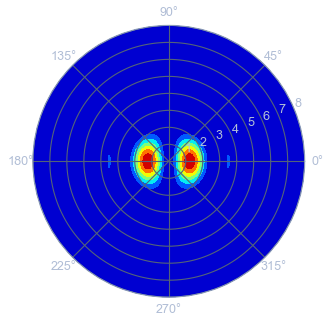

In [23]:
#angular momentum value
l = 1
#index of the energy level
k = 1
#z angular momentum
m = 0

#Calculate the radial part of the wavefunction
r,f_r = qd_scatter_data.norm_wavefunction(l,k)
phi = np.linspace(0,2*np.pi,100)
#Angular part of the wavefunction
y_lm = np.absolute(special.sph_harm(m,l,0,phi))**2
#Combine both radial and angular parts
psi = np.array([y_lm*f_r_i for f_r_i in f_r])
#Grid for exportation purposes
Phi, R = np.meshgrid(phi,r)

#actual plotting
ax = plt.subplot(111, polar=True)
ctf = ax.contourf(phi,r,psi, cmap=cm.jet)
pd.DataFrame({"dummy":psi.flatten()}).to_clipboard(index = False,header = False)

In [6]:
#Solve the egenvalue problem for specific values (a = 5 nm, V0 = 1.15 eV, m1 = m2 = 0.08)
qd_scatter_data = qd_results(5,1.15,0.08,0.08)

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [189]:
qd_scatter_data.e_levels

,l0,l1,l2,l3,l4
0,-1.00318,-0.85109,-0.66111,-0.43651,-0.18085
1,-0.57434,-0.29576,-0.00816,NaN,NaN


In [234]:
psi

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.41111973e-06, 2.40142077e-06, 2.37247997e-06, ...,
        2.37247997e-06, 2.40142077e-06, 2.41111973e-06],
       [9.64218625e-06, 9.60339965e-06, 9.48766395e-06, ...,
        9.48766395e-06, 9.60339965e-06, 9.64218625e-06],
       ...,
       [3.42048653e-10, 3.40672730e-10, 3.36567101e-10, ...,
        3.36567101e-10, 3.40672730e-10, 3.42048653e-10],
       [3.18104282e-10, 3.16824678e-10, 3.13006454e-10, ...,
        3.13006454e-10, 3.16824678e-10, 3.18104282e-10],
       [2.95840344e-10, 2.94650299e-10, 2.91099310e-10, ...,
        2.91099310e-10, 2.94650299e-10, 2.95840344e-10]])

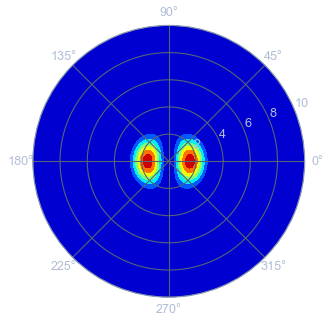

In [22]:
#angular momentum value
l = 1
#index of the energy level
k = 1
#z angular momentum
m = 0

#Calculate the radial part of the wavefunction
r,f_r = qd_scatter_data.norm_wavefunction(l,k)
phi = np.linspace(0,2*np.pi,100)
#Angular part of the wavefunction
y_lm = np.absolute(special.sph_harm(m,l,0,phi))**2
#Combine both radial and angular parts
psi = np.array([y_lm*f_r_i for f_r_i in f_r])
#Grid for exportation purposes
Phi, R = np.meshgrid(phi,r)

#actual plotting
ax = plt.subplot(111, polar=True)
ctf = ax.contourf(phi,r,psi, cmap=cm.jet)
pd.DataFrame({"dummy":psi.flatten()}).to_clipboard(index = False,header = False)

In [11]:
R.flatten()

array([ 0.,  0.,  0., ..., 10., 10., 10.])

## Test calculation of matrix elements

In [107]:
test_qd = qd_results(5,1,1,1)

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [8]:
#Calculate the first transition, example from Gasiorowicz hydrogen 2p->1s transition
#Properties
# l = 1 --> l = 0
# n = 0 --> n = 0
# m = 1,0,-1 --> 0

#Calculate radial elements
rad_element = test_qd.rad_matrix_element((1,0),(0,0))

m_0_ang_element = test_qd.ang_matrix_element((1,0),(0,0))
m_1_ang_element = test_qd.ang_matrix_element((1,1),(0,0))
m__1_ang_element = test_qd.ang_matrix_element((1,-1),(0,0))

print(rad_element,m_0_ang_element,m_1_ang_element,m__1_ang_element)

2.75077285188502 (0.577350269189626, 0, 0) (0, -0.408248290463863, 0) (0, 0, -0.408248290463863)


C:\Users\cemop\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:450: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


In [ ]:
test_qd.ang_matrix_element()

In [9]:
# def ang_matrix_element(i_state,f_state):
#     """
#     Calculates the angular part of the matrix elements

#     Args:
#         i_state (tuple): l and m values for the initial state
#         f_state (tuple): l and m values for the final state

#     Returns:
#         ep_x,ep_circ_1,ep_circ_2: Components for each polarization
#     """
#     li, mi = i_state
#     lf, mf = f_state

#     pre_factor = np.sqrt((2*li+1)/(2*lf+1))*CG(1,0,li,0,lf,0).doit()

#     ep_z = pre_factor*CG(1,0,li,mi,lf,mf).doit()#z polarization
#     ep_circ_left = pre_factor*CG(1,-1,li,mi,lf,mf).doit()*(1/np.sqrt(2))#left circular polarization (ex+iey)
#     ep_circ_right = pre_factor*CG(1,1,li,mi,lf,mf).doit()*(1/np.sqrt(2))#right circular polarization (-ex+iey)

#     return ep_z,ep_circ_left,ep_circ_right#Calculates the angular matrix elements#Calculates the angular matrix element

In [10]:
test_m0 = ang_matrix_element((1,0),(0,0))
test_m1 = ang_matrix_element((1,1),(0,0))
test_m_1 = ang_matrix_element((1,-1),(0,0))

print(test_m0,test_m1,test_m_1)

(0.577350269189626, 0, 0) (0, -0.408248290463863, 0) (0, 0, -0.408248290463863)


## Determine all the transition elements between 2 l states

In [50]:
test_qd = qd_results(5,1,1,1)

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [109]:
# def total_transition_rate(li,lf):
#     """
#     Calculates the total transition rate given an inital and final l values
    
#     Args:
#         li: initial value for the orbital angular momentum
#         lf: final value for the orbital angular momentum
        
#     Retuns:
#         ang_elements: numpy array, size (2*lf+1,2*li+1,3) with all the matrix elements between transitions
#     """
#     #Create a list with all the necessary m values
#     m_i = np.arange(-li,li+1)
#     m_f = np.arange(-lf,lf+1)
#     M_i,M_f = np.meshgrid(m_i,m_f)#Create an array with the parameters variations
    
#     M_i,M_f = list(M_i.flatten()),list(M_f.flatten())#Flatten the data to use in the map function
    
#     ang_elements = np.array(list(map(lambda x,y: test_qd.ang_matrix_element((li,x),(lf,y)),M_i,M_f)),dtype=float).reshape(2*lf+1,2*li+1,3)
    
#     return ang_elements

In [51]:
test_qd.all_ang_matrix_elements(2,1)

(array([[[ 0.        ,  0.        , -0.4472136 ],
         [ 0.4472136 ,  0.        ,  0.        ],
         [ 0.        , -0.18257419,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        , -0.31622777],
         [ 0.51639778,  0.        ,  0.        ],
         [ 0.        , -0.31622777,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        , -0.18257419],
         [ 0.4472136 ,  0.        ,  0.        ],
         [ 0.        , -0.4472136 ,  0.        ]]]),
 array([ 0.47027499, -0.31533852, -0.31533852]))

## Plot the absorption profile

In [68]:
#Function to plot the absorption profiles
def part_gaussian(energy,t_energy,matrix_elements,gauss_dispersion = 0.025,qd_density = (1/50,1/50,1/50),n_index = 2):
    """
    Gaussian absortpion profile for energy transition from an initial to a final state
    Args:
        energy (array - eV): Base array to calculate y values
        t_energy (float - eV): Transition energy (term in the difference between initial and final states)
        gauss_dispersion (float - eV): Dispersion value for the gaussian (default - 0.025 eV)
        matrix_elements (tuple - nm): Matrix elements for the different polarizations
        qd_density (tuple nm^-1): linear qd density for the 3 different dimensions (default - (1/5nm,1/5nm,1/5nm))
        n_index (array): array with the refractive indexes - should have the same shape as energy (default = 2)
    Returns:
        abs_ij (array - cm^-1): Absorption for the transition i->j
    """
    #Initialize necessary constants
    q, h, c, e0 = 1.6022*10**-19, 6.626*10**-34, 2.9979*10**8, 8.8542*10**-12 #C,J.s,m/s,C^2/(N.m^2)
    #Convert matrix elements from nm to m
    matrix_elements_nm = matrix_elements*10**-9
    #Calculate the fraction responsible for the units
    constant_fraction = ((2*np.pi**2*q**2*energy)/(n_index*c*h*e0))
    #Fraction for the volumetrica part of the QDs in the bulk material and conversion to m
    rho_density = qd_density[0]*qd_density[1]*qd_density[2]*(10**9)**3
    volume_fraction = (6*rho_density)/np.pi#Volumetric fraction of QDs
    #Define the delta function in terms of a gaussian profiule
    delta = (1/(np.sqrt(np.pi)*sigma))*np.exp(-((energy-t_energy)/gauss_dispersion)**2)
    abs_ij = 2*matrix_elements_nm**2*constant_fraction*volume_fraction*delta
    return abs_ij/100

In [69]:
wav = np.linspace(0,1,500) #Wavelength in eV
sigma = 0.025 
#Dispersion in eV

In [70]:
abs_prof_qd = qd_results(1,1,1,1)#calculate the results

C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in less
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\cemop\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [71]:
#Determine transition from 1st to 2nd level (l=0-->l=1)
rad_element = abs_prof_qd.rad_matrix_element((0,0),(1,0))
_,ang_elements = abs_prof_qd.all_ang_matrix_elements(0,1)
transition_energy = abs(abs_prof_qd.e_levels['l0'][0]-abs_prof_qd.e_levels['l1'][0])
print(rad_element,ang_elements,transition_energy)

0.5726911569088663 [0.57735027 0.40824829 0.40824829] 0.26197000000000004


C:\Users\cemop\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:450: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


In [72]:
abs_prof_qd.e_levels

,l0,l1,l2
0,-0.74094,-0.47897,-0.16433
1,-0.06154,NaN,NaN


In [73]:
absorption = part_gaussian(wav,transition_energy,rad_element*ang_elements[:,np.newaxis])

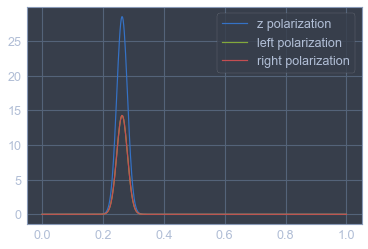

In [74]:
plt.plot(wav,absorption[0],wav,absorption[1],wav,absorption[2])
plt.legend(['z polarization','left polarization','right polarization'])